### 7FNCE041W - Coursework
### Data Import via yfinance

Data was imported using yfinance. The chosen SP 500 Index was eBay.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
import yfinance as yf
import mibian as mb

In [3]:
data = yf.download("EBAY", start="2020-03-01", end="2021-03-02")

[*********************100%***********************]  1 of 1 completed


In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-02,34.619999,35.970001,34.279999,35.959999,35.500446,13131000
2020-03-03,35.730000,37.419998,35.660000,36.720001,36.250732,18838700
2020-03-04,37.320000,38.540001,37.139999,38.490002,37.998116,13445400
2020-03-05,37.480000,38.220001,37.070000,37.220001,36.744343,11816600
2020-03-06,35.709999,36.790001,35.590000,36.389999,35.924953,12849800


In [5]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-23,60.680000,61.730000,59.820000,61.369999,61.176132,5826500
2021-02-24,60.990002,61.049999,58.830002,59.380001,59.192421,8050000
2021-02-25,59.400002,59.970001,56.849998,56.980000,56.799999,7868300
2021-02-26,57.340000,57.660000,56.250000,56.419998,56.419998,9013500
2021-03-01,57.099998,58.700001,56.529999,58.480000,58.480000,6153700


### Adjusted Close
Adj close refers to the final price after adjusting dividend distributions and applicable splits. In a period of a year, eBay's ADJ close went from 35.50 to 58.48.

In [6]:
ADJ = data['Adj Close']

In [7]:
ADJ

Date
2020-03-02    35.500446
2020-03-03    36.250732
2020-03-04    37.998116
2020-03-05    36.744343
2020-03-06    35.924953
                ...    
2021-02-23    61.176132
2021-02-24    59.192421
2021-02-25    56.799999
2021-02-26    56.419998
2021-03-01    58.480000
Name: Adj Close, Length: 252, dtype: float64

Text(0, 0.5, 'Adj Close')

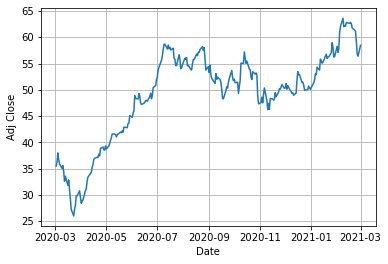

In [8]:
fig = plt.figure()
plt.plot( ADJ, '-')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Adj Close')

### Annualised Volatility
Volatility refers to the rate at which the value of an option may go up or go down. Volatility is estimated by calculating the standard deviation of the annualized returns over a given period of time. eBay's annualised volatility is 37.59 % (12M) and 36.71 % (6M).

In [9]:
log_return = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

Annualised volatility for a twelve-month period

In [10]:
vol = np.sqrt(252) * log_return.std()
print('The annualised volatility is', round(vol*100,2), '%')

The annualised volatility is 37.59 %


Annualised volatility for a six-month period

In [11]:
Sixlr = log_return[125:-1]

In [12]:
Sixlr

Date
2020-08-27   -0.039521
2020-08-28   -0.036900
2020-08-31    0.012306
2020-09-01   -0.020844
2020-09-02    0.026487
                ...   
2021-02-22   -0.006799
2021-02-23   -0.003091
2021-02-24   -0.032964
2021-02-25   -0.041257
2021-02-26   -0.006713
Name: Adj Close, Length: 126, dtype: float64

In [13]:
Vol = np.sqrt(252) * Sixlr.std()
print('The annualised volatility is', round(Vol*100,2), '%')

The annualised volatility is 36.71 %


### Binomial Tree (CRR Tree)
This model represents intrinsic values that an option pricing might possible over a given period of time. Therefore, it has shown the possible values that eBay's stock price may have over a period of three months. Further, the BTM determines that binary put option equals to 1.

In [14]:
S0 = data['Adj Close'][-1]      # spot stock price      
K = 60                          # strike
T = 3/12                        # maturity 
r = 0.0167                      # risk free rate 
sig = 0.4                       # diffusion coefficient or volatility
N = 3                           # number of periods or number of time steps 
payoff = "put"                  # payoff

In [15]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor

In [16]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [17]:
S

array([[58.47999954, 65.63800426, 73.67215522, 82.6896935 ],
       [ 0.        , 52.10259491, 58.47999954, 65.63800426],
       [ 0.        ,  0.        , 46.42066377, 52.10259491],
       [ 0.        ,  0.        ,  0.        , 41.35836283]])

In [18]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.4771814275585755

In [19]:
S_T = S[:,-1]
S_T

array([82.6896935 , 65.63800426, 52.10259491, 41.35836283])

In [20]:
np.heaviside

<ufunc 'heaviside'>

In [25]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
V[:,-1] = np.heaviside(K>S_T, 0.0)
V

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

#### Binary Put Option Pricing

In [23]:
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[0.53197844, 0.27257952, 0.        , 0.        ],
       [0.        , 0.77015131, 0.52209149, 0.        ],
       [0.        , 0.        , 0.9986093 , 1.        ],
       [0.        , 0.        , 0.        , 1.        ]])

In [24]:
print('Binary ' + payoff, str( V[0,0]))

Binary put 0.5319784431651534


### Monte Carlo Simulation
This methods consists of computational algorithms that derivate random samples to get numerical results, thereby simulating stock prices over a period of time. Here, we chose to simulate the asset price 1000 times, with 90 steps.

In [27]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [28]:
T = 3/12
r = 0.0167
sigma = np.sqrt(252) * log_return.std() 
S0 = data['Adj Close'][-1]
K = 100

In [29]:
S = mcs_simulation_np (1000)

In [30]:
S = np.transpose(S)
S

array([[58.47999954, 58.26953189, 58.32893501, ..., 73.43535299,
        74.21138042, 74.23040124],
       [58.47999954, 58.08056335, 58.2771544 , ..., 50.13551939,
        50.92337028, 50.67874491],
       [58.47999954, 58.42500469, 58.32441568, ..., 58.88044492,
        59.2180072 , 58.96438276],
       ...,
       [58.47999954, 57.72503567, 57.77544539, ..., 54.3390985 ,
        54.13983353, 54.40520077],
       [58.47999954, 58.59855544, 57.73517898, ..., 51.02815723,
        51.27397016, 51.36811457],
       [58.47999954, 58.36710523, 58.48875435, ..., 79.80816381,
        78.8658531 , 78.88016733]])

Histogram for S_T

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-period values')

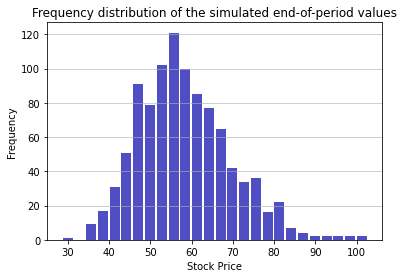

In [31]:
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Stock Price')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-period values')

#### Binary Options

In [37]:
p = np.mean(np.heaviside(K > S[:,-1],0))
p
print('Binary put', str(p))

Binary put 0.998


### Greeks
This refers to tools that help to predict the sensibility of an option in response to underlying

### Surface of Delta
Δ estimates how sensitive the option value is concerning stock price changes. Delta put is expressed as a negative, indicating then that option value goes down when stock price increases and vice-versa.

In [38]:
def delta(S, K, r, vol, T, t, payoff):
    
    d1 = (np.log(S / K) + (r - t + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    
    if payoff == "call":
        delta = np.exp(- (T - t)) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta = -np.exp(- (T - t)) * si.norm.cdf(-d1, 0.0, 1.0)

    return delta

In [39]:
delta(58.48, 60, 3/12, 0.4, 0.121, 0.37, 'call')

0.5300887024577678

In [40]:
delta(58.48, 60, 3/12, 0.4, 0.121, 0.37, 'put')

-0.7526533306120435

In [130]:
S = np.linspace(30,60,90)
Delta_Call = np.zeros((len(S),1))
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Call [i] = delta(S[i], 60, 3/12, 0.4, 0.121, 0.37, 'call')
    Delta_Put [i] = delta(S[i], 60, 3/12, 0.4, 0.121, 0.37, 'put')

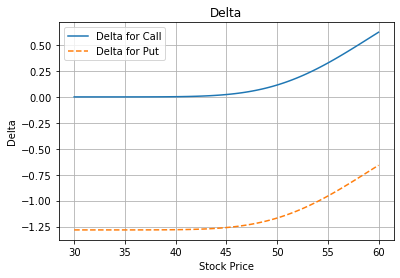

In [131]:
fig = plt.figure()
plt.plot(S, Delta_Call, '-')
plt.plot(S, Delta_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call','Delta for Put'])

### Surface of Gamma
Γ estimates the option value change rate per one point movement, with respect to the underlying asset price.

In [132]:
def gamma(S, K, r, vol, T, t, payoff):
    
    d1 = (np.log(S / K) + (r - t + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- (T - t)) * si.norm.pdf(-d1, 0.0, 1.0) / ( S * vol * np.sqrt(T))
    
    return gamma

In [133]:
gamma(58.48, 60, 3/12, 0.4, 0.121, 0.37, 'call')

0.061398191245293214

In [134]:
gamma(58.48, 60, 3/12, 0.4, 0.121, 0.37, 'put')

0.061398191245293214

In [135]:
S = np.linspace(30,60,90)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 60, 3/12, 0.4, 0.121, 0.37, 'call')

### Surface of Speed
Speed estimates Gamma's change rate as changes occur in the underlying asset price.

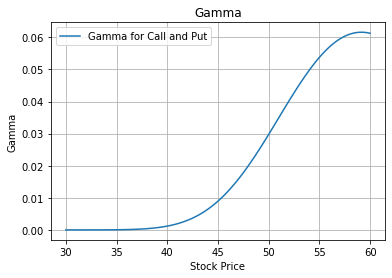

In [136]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call and Put'])

In [113]:
def speed(S, K, r, vol, T, t, payoff):
    
    d1 = (np.log(S / K) + (r - t + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = np.exp(-t * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [114]:
speed(58.48, 60, 3/12, 0.4, 0.121, 0.37, 'call')

-0.00015664919754163179

In [115]:
speed(58.48, 60, 3/12, 0.4, 0.121, 0.37, 'put')

-0.00015664919754163179

In [137]:
S = np.linspace(30,60,11)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i], 60, 3/12, 0.4, 0.121, 0.37, 'put')

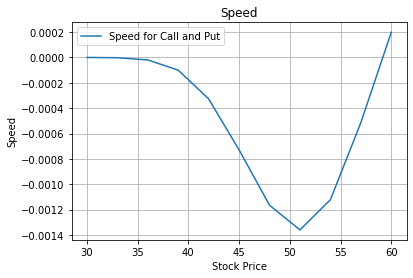

In [138]:
fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Call and Put'])

### Surface of Theta
Θ is the decline rate in options value over time. It helps to understand how options value decay over a period of time. Θ portrays time and option value loss risk. Just like Δ, Θ is expressed as a negative value.

In [139]:
def theta(S, K, r, vol, T, t, payoff):
    
    d1 = (np.log(S / K) + (r - t + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - t + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = S * si.norm.pdf(d1, 0.0, 1.0) * vol / (2 * np.sqrt(T)) - r * K * np.exp(-r * (T-t)) * si.norm.pdf(d2, 0.0, 1.0) 
    elif payoff == "put":
        theta = - S * si.norm.pdf(d1, 0.0, 1.0) *vol / (2 * np.sqrt(T)) + r * K * np.exp(-r * (T-t)) * si.norm.pdf(-d2, 0.0, 1.0)

    return theta

In [140]:
theta(58.48, 60, 3/12, 0.4, 0.121, 0.37, 'call')

6.8781582692670415

In [59]:
theta(58.48, 60, 3/12, 0.4, 0.121, 0.37, 'put')

-6.8781582692670415

In [143]:
T = np.linspace(0.03,0.25, 12)
Theta_Call = np.zeros((len(T),1))
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Call [i] = theta(58.48, 60, T[i], 0.4, 0.121, 0.37, 'call')
    Theta_Put [i] = theta(58.48, 60, T[i], 0.4, 0.121, 0.37, 'put')

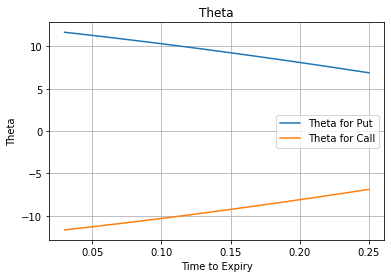

In [144]:
fig = plt.figure()
plt.plot(T, Theta_Call, '-')
plt.plot(T, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Put', 'Theta for Call'])

### Surface Vega
Vega estimates how sensitive the option value is with respect to a 1% change in volatility. 

In [63]:
def vega(S, K, r, vol, T, t, payoff):
    
    d1 = (np.log(S / K) + (r - t + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * si.norm.pdf(d1, 0.0, 1.0) * np.exp(-(T-t))
    
    return vega

In [73]:
vega(58.48, 60, 3/12, 0.4, 0.121, 0.37, 'call')

29.21614973515835

In [74]:
vega(58.48, 60, 3/12, 0.4, 0.121, 0.37, 'put')

29.21614973515835

In [94]:
vol = np.linspace(0.1,2,10)
Vega = np.zeros((len(vol),1))
for i in range(len(vol)):
    Vega [i] = vega(58.48, 60, 3/12, 0.4, 0.121, vol[i], 'call')

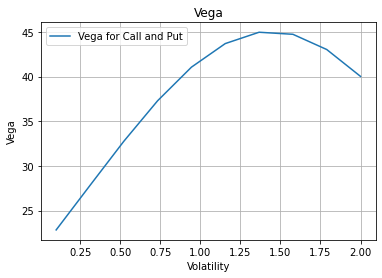

In [95]:
fig = plt.figure()
plt.plot(vol, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Call and Put'])